# Prep and Load Data

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/NLP/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/NLP/sentiment_classification/data/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
# create data loader

from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import pandas as pd

tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거와 NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')

    # 한국어 토크나이저로 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 1)
    word_to_index = {word: index + 1 for index, (word, _) in enumerate(counter)}  # 인덱스 0은 패딩을 위해 비워둠

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train = list(map(lambda sentence: [word_to_index[word] if word in word_to_index else 0 for word in sentence], X_train))
    X_test = list(map(lambda sentence: [word_to_index[word] if word in word_to_index else 0 for word in sentence], X_test))

    # 레이블 데이터 준비
    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])

    return X_train, y_train, X_test, y_test, word_to_index


x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)


In [12]:
x_train[0]

[29, 71, 916, 1, 1, 36, 225, 17, 30, 745]

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


## Data Analysis and processing for Model Creation
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

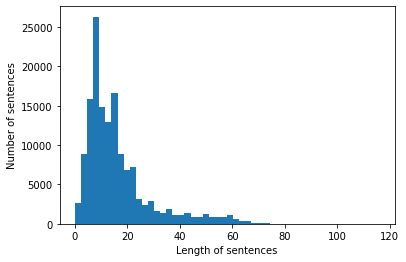

Average length:  15.98170773419436
Max length:  116
Standard deviation:  12.82473766384545


In [17]:
import matplotlib.pyplot as plt

# 문장 길이 분포 확인
sentence_lengths = [len(sentence) for sentence in X_train]
plt.hist(sentence_lengths, bins=50)
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')
plt.show()

# 평균과 최대, 표준편차 확인
print("Average length: ", np.mean(sentence_lengths))
print("Max length: ", np.max(sentence_lengths))
print("Standard deviation: ", np.std(sentence_lengths))


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 40

# 패딩 추가
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')

# 결과 확인
print(X_train_padded.shape)
print(X_test_padded.shape)


(146182, 40)
(49157, 40)


## Model Creation and Training

In [19]:
# model 1 - vanilla LSTM

import tensorflow as tf

vocab_size = 10000
word_vector_dim = 16

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model 2 -stacked LSTM

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(16, return_sequences=True))  # return_sequences=True is necessary for stacking
model2.add(tf.keras.layers.LSTM(8))
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 16)          2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 162,993
Trainable params: 162,993
Non-trainable params: 0
_________________________________________________________________


In [27]:
# model 3 - LSTM with Conv1D

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1040      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [22]:
# val set

# Assuming you've already padded your sequences as X_train_padded and have labels in y_train
from sklearn.model_selection import train_test_split

# Split the training data to create a validation set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

print(f'Training set size: {X_train_split.shape[0]}')
print(f'Validation set size: {X_val_split.shape[0]}')


Training set size: 116945
Validation set size: 29237


## Train!

In [29]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [24]:
epochs = 10
batch_size = 64

history1 = model1.fit(X_train_split, y_train_split,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_split, y_val_split),
                    verbose=1)


Epoch 1/10
1828/1828 [==============================] - 13s 5ms/step - loss: 0.4256 - accuracy: 0.7935 - val_loss: 0.3563 - val_accuracy: 0.8477
Epoch 2/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.3264 - accuracy: 0.8588 - val_loss: 0.3569 - val_accuracy: 0.8482
Epoch 3/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.3030 - accuracy: 0.8672 - val_loss: 0.3547 - val_accuracy: 0.8467
Epoch 4/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2838 - accuracy: 0.8761 - val_loss: 0.3601 - val_accuracy: 0.8517
Epoch 5/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2669 - accuracy: 0.8825 - val_loss: 0.3627 - val_accuracy: 0.8473
Epoch 6/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2513 - accuracy: 0.8895 - val_loss: 0.3680 - val_accuracy: 0.8543
Epoch 7/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2360 - accuracy: 0.8974 - val_loss: 0.3770 - val_ac

In [25]:

history2 = model2.fit(X_train_split, y_train_split,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_split, y_val_split),
                    verbose=1)


Epoch 1/10
1828/1828 [==============================] - 17s 8ms/step - loss: 0.4128 - accuracy: 0.8035 - val_loss: 0.3572 - val_accuracy: 0.8431
Epoch 2/10
1828/1828 [==============================] - 14s 8ms/step - loss: 0.3261 - accuracy: 0.8592 - val_loss: 0.3421 - val_accuracy: 0.8518
Epoch 3/10
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2954 - accuracy: 0.8713 - val_loss: 0.3522 - val_accuracy: 0.8559
Epoch 4/10
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2707 - accuracy: 0.8827 - val_loss: 0.3472 - val_accuracy: 0.8535
Epoch 5/10
1828/1828 [==============================] - 14s 8ms/step - loss: 0.2507 - accuracy: 0.8930 - val_loss: 0.3625 - val_accuracy: 0.8534
Epoch 6/10
1828/1828 [==============================] - 14s 7ms/step - loss: 0.2325 - accuracy: 0.9017 - val_loss: 0.3661 - val_accuracy: 0.8541
Epoch 7/10
1828/1828 [==============================] - 14s 7ms/step - loss: 0.2175 - accuracy: 0.9094 - val_loss: 0.3742 - val_ac

In [30]:

history3 = model3.fit(X_train_split, y_train_split,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_split, y_val_split),
                    verbose=1)


Epoch 1/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.4636 - accuracy: 0.8058 - val_loss: 0.3842 - val_accuracy: 0.8457
Epoch 2/10
1828/1828 [==============================] - 8s 4ms/step - loss: 0.3253 - accuracy: 0.8727 - val_loss: 0.3545 - val_accuracy: 0.8468
Epoch 3/10
1828/1828 [==============================] - 8s 5ms/step - loss: 0.2614 - accuracy: 0.8998 - val_loss: 0.3585 - val_accuracy: 0.8461
Epoch 4/10
1828/1828 [==============================] - 8s 4ms/step - loss: 0.2118 - accuracy: 0.9229 - val_loss: 0.3974 - val_accuracy: 0.8451
Epoch 5/10
1828/1828 [==============================] - 8s 4ms/step - loss: 0.1739 - accuracy: 0.9396 - val_loss: 0.4413 - val_accuracy: 0.8395
Epoch 6/10
1828/1828 [==============================] - 8s 4ms/step - loss: 0.1455 - accuracy: 0.9505 - val_loss: 0.4901 - val_accuracy: 0.8416
Epoch 7/10
1828/1828 [==============================] - 8s 4ms/step - loss: 0.1245 - accuracy: 0.9596 - val_loss: 0.5638 - val_accuracy

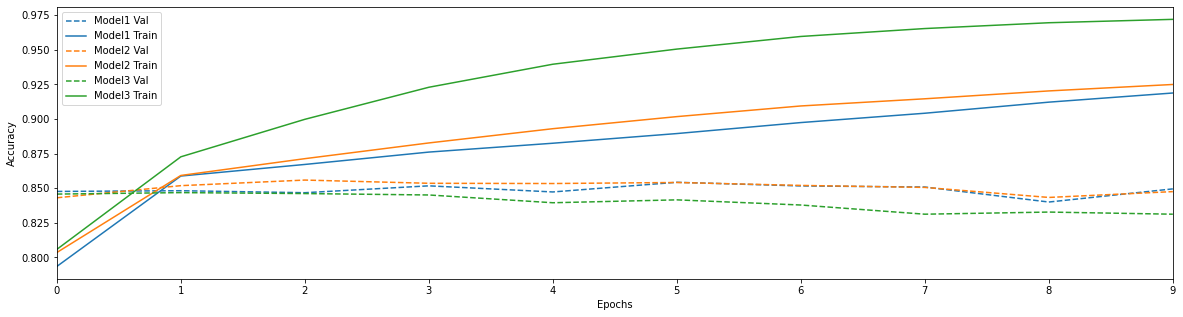

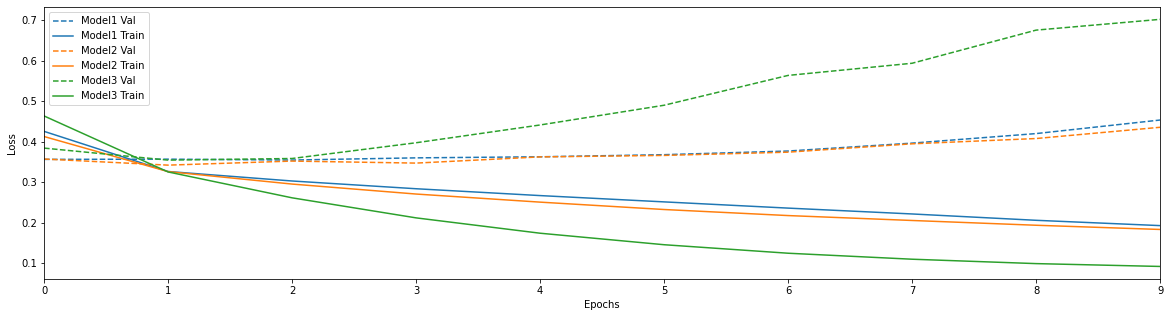

In [31]:
# viz

import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(20, 5))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])
    plt.show()

# Plotting training and validation accuracy
plot_history([('model1', history1),
              ('model2', history2),
              ('model3', history3)],
             key='accuracy')

# Plotting training and validation loss
plot_history([('model1', history1),
              ('model2', history2),
              ('model3', history3)],
             key='loss')


## Import Korean Word2Vec

In [35]:
from gensim.models import Word2Vec

# Assuming the Word2Vec model's path is /data/word2vec_ko.model
word2vec_file_path = '/aiffel/data/word2vec_ko.model'
word_vectors = Word2Vec.load(word2vec_file_path).wv


In [36]:
vocab_size = len(word_to_index) + 1  # Plus 1 for zero padding
word_vector_dim = word_vectors.vector_size  # Word2Vec의 벡터 사이즈

# 초기화
embedding_matrix = np.zeros((vocab_size, word_vector_dim))

# word_to_index에서 <BOS>, <UNK>, <PAD> 등을 처리하지 않았다면, 이를 고려해야 함
for word, i in word_to_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


In [38]:
model_f = tf.keras.Sequential()
model_f.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, 
                                    weights=[embedding_matrix], 
                                    input_length=max_len, 
                                    trainable=False))  # Do not update the pre-trained embeddings
model_f.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_f.add(tf.keras.layers.LSTM(8))
model_f.add(tf.keras.layers.Dense(8, activation='relu'))
model_f.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_f.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 16)            7488      
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 1,008,369
Trainable params: 8,369
Non-trainable params: 1,000,000
_________________________________________________________________


In [40]:
# 학습의 진행
model_f.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_f = model_f.fit(X_train_split, y_train_split,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_split, y_val_split),
                    verbose=1)


Epoch 1/10
1828/1828 [==============================] - 16s 7ms/step - loss: 0.5119 - accuracy: 0.7457 - val_loss: 0.4512 - val_accuracy: 0.7931
Epoch 2/10
1828/1828 [==============================] - 13s 7ms/step - loss: 0.4274 - accuracy: 0.8038 - val_loss: 0.4219 - val_accuracy: 0.8046
Epoch 3/10
1828/1828 [==============================] - 13s 7ms/step - loss: 0.3979 - accuracy: 0.8192 - val_loss: 0.4051 - val_accuracy: 0.8168
Epoch 4/10
1828/1828 [==============================] - 13s 7ms/step - loss: 0.3804 - accuracy: 0.8292 - val_loss: 0.3909 - val_accuracy: 0.8239
Epoch 5/10
1828/1828 [==============================] - 13s 7ms/step - loss: 0.3699 - accuracy: 0.8349 - val_loss: 0.3828 - val_accuracy: 0.8264
Epoch 6/10
1828/1828 [==============================] - 13s 7ms/step - loss: 0.3609 - accuracy: 0.8386 - val_loss: 0.3867 - val_accuracy: 0.8222
Epoch 7/10
1828/1828 [==============================] - 13s 7ms/step - loss: 0.3553 - accuracy: 0.8410 - val_loss: 0.3752 - val_ac

In [42]:
# 테스트셋을 통한 모델 평가
results = model_f.evaluate(x_test,  y_test, verbose=2)

print(results)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'int\'>"})', "(<class 'list'> containing values of types set())"}), <class 'numpy.ndarray'>

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming max_len is defined (the maximum length you've used for your training data)
# Convert x_test to a NumPy array with proper padding
x_test_padded = pad_sequences(x_test, maxlen=max_len, padding='post')

# Ensure y_test is also a numpy array if it's not already
y_test_array = np.array(y_test)

# Now evaluate the model with the properly formatted data
results = model_f.evaluate(x_test_padded,  y_test_array, verbose=2)

print(results)


1537/1537 - 4s - loss: 0.3734 - accuracy: 0.8329
[0.37337562441825867, 0.8329230546951294]
